<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/12-custom-models-and-training-with-tensorflow/03_customizing_models_and_araining_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Customizing Models and Training Algorithms

In fact, 95% of the use cases you will encounter will not require anything other than `tf.keras` and `tf.data`.

But now it’s time to dive deeper into TensorFlow
and take a look at its lower-level Python API. This will be useful when you need extra
control to write custom loss functions, custom metrics, layers, models, initializers,
regularizers, weight constraints, and more. 

You may even need to fully control the
training loop itself, for example to apply special transformations or constraints to the
gradients (beyond just clipping them) or to use multiple optimizers for different parts
of the network.

TensorFlow’s API revolves around tensors, which flow from operation to operation—hence the name TensorFlow.

A tensor is very similar to a NumPy ndarray: it is usually
a multidimensional array, but it can also hold a scalar (a simple value, such as 42).
These tensors will be important when we create custom cost functions, custom metrics,
custom layers, and more, so let’s see how to create and manipulate them.



##Setup

In [1]:
import sys
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import time

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Custom Loss

Let's start by loading and preparing the California housing dataset. 

In [2]:
housing = fetch_california_housing()

x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

Let's implement the Huber loss.

In [3]:
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss = tf.square(error) / 2
  linear_loss  = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

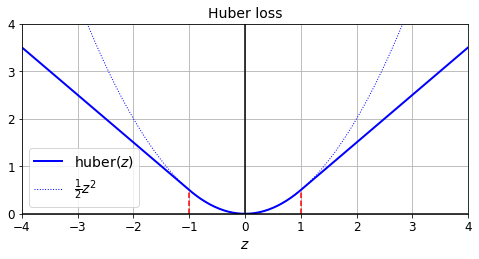

In [4]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [5]:
input_shape = x_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [6]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [7]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


**Saving and loading models with custom components**

In [8]:
model.save("my_model_with_a_custom_loss.h5")

In [9]:
# need to provide a dictionary that maps the function name to the actual function.
model = keras.models.load_model("my_model_with_a_custom_loss.h5", custom_objects={"huber_fn": huber_fn})

In [10]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


But what if you want a different threshold? 

One solution is to create a function that
creates a configured loss function:

In [11]:
def create_huber(threshold=1.0):
  def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error) / 2
    linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)
  return huber_fn

In [12]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [13]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 2s 6ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [14]:
model.save("my_model_with_a_custom_loss_2.h5")

Unfortunately, when you save the model, the threshold will not be saved.so need to specify the threshold value.

In [15]:
model = keras.models.load_model("my_model_with_a_custom_loss_2.h5", custom_objects={"huber_fn": create_huber(2.0)})

In [16]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 6ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


You can solve this by creating a subclass of the keras.losses.Loss class, and then implementing its `get_config()` method:

In [17]:
class HuberLoss(keras.losses.Loss):
  def __init__(self, threshold=1.0, **kwargs) -> None:
    self.threshold = threshold
    super().__init__(**kwargs)

  def call(self, y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < self.threshold
    squared_loss = tf.square(error) / 2
    linear_loss  = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)

  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "threshold": self.threshold}

In [18]:
model.compile(loss=HuberLoss(2.0), optimizer="nadam", metrics=["mae"])

In [19]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.2094 - mae: 0.4729 - val_loss: 0.1980 - val_mae: 0.4537
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2068 - mae: 0.4692 - val_loss: 0.2031 - val_mae: 0.4621


In [20]:
model.save("my_model_with_a_custom_loss_class.h5")

In [21]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", custom_objects={"HuberLoss": HuberLoss(2.0)})

In [22]:
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2051 - mae: 0.4670 - val_loss: 0.1952 - val_mae: 0.4491
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2028 - mae: 0.4632 - val_loss: 0.2183 - val_mae: 0.4663


In [23]:
# let's check threshold value
model.loss.threshold

2.0

##Other Custom Functions

Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics,
activation functions, layers, and even full models, can be customized in very
much the same way.

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
  return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
  stddev = tf.sqrt(2. / (shape[0] + shape[1]))
  return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
  return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
  return tf.where(weights < 0., tf.zeros_like(weights), weights)

These custom
functions can then be used normally;

In [26]:
layer = keras.layers.Dense(1, 
                           activation=my_softplus, 
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
model = keras.models.Sequential([
    keras.layers.Dense(30, 
                       activation="selu", 
                       kernel_initializer="lecun_normal", 
                       input_shape=input_shape),
    keras.layers.Dense(1, 
                       activation=my_softplus, 
                       kernel_initializer=my_glorot_initializer,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights)
])

In [31]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 6ms/step - loss: 2.3330 - mae: 0.9736 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.8556 - mae: 0.5399 - val_loss: inf - val_mae: inf


In [32]:
model.save("my_model_with_many_custom_parts.h5")
model = keras.models.load_model("my_model_with_many_custom_parts.h5", 
                                custom_objects={
                                    "my_l1_regularizer": my_l1_regularizer,
                                    "my_positive_weights": my_positive_weights,
                                    "my_glorot_initializer": my_glorot_initializer,
                                    "my_softplus": my_softplus
                                    })
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6759 - mae: 0.5122 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5879 - mae: 0.4980 - val_loss: inf - val_mae: inf


If a function has hyperparameters that need to be saved along with the model, then
you will want to subclass the appropriate class.

In [34]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
class MyL1Regularizer(keras.regularizers.Regularizer):
  def __init__(self, factor) -> None:
    self.factor = factor
  def __call__(self, weights):
    return tf.reduce_sum(tf.abs(self.factor * weights))
  def get_config(self):
    return {"factor": self.factor}

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, 
                       activation="selu", 
                       kernel_initializer="lecun_normal", 
                       input_shape=input_shape),
    keras.layers.Dense(1, 
                       activation=my_softplus, 
                       kernel_initializer=my_glorot_initializer,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights)
])

In [37]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [38]:
model.save("my_model_with_many_custom_parts.h5")
model = keras.models.load_model("my_model_with_many_custom_parts.h5", 
                                custom_objects={
                                    "MyL1Regularizer": MyL1Regularizer,
                                    "my_positive_weights": my_positive_weights,
                                    "my_glorot_initializer": my_glorot_initializer,
                                    "my_softplus": my_softplus
                                  })
model.fit(x_train_scaled, y_train, epochs=2, validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5240 - mae: 0.4971 - val_loss: 0.9955 - val_mae: 0.4869
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5020 - mae: 0.4873 - val_loss: 0.9798 - val_mae: 0.4882


##Custom Metrics